In [1]:
# QViT-DR: Quantum-Enhanced Vision Transformer for Diabetic Retinopathy Grading
# A comprehensive implementation for the Kaggle environment

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            roc_auc_score, cohen_kappa_score, roc_curve, auc)

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50

import pywt  # PyWavelets for wavelet transform
import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

import warnings
warnings.filterwarnings("ignore")

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# --------------------- DATASET PREPARATION ---------------------

# Configure dataset paths - adjust based on your Kaggle environment
# For APTOS 2019 dataset
DATA_DIR = '/kaggle/input/aptos2019-blindness-detection'
TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
TEST_IMAGES_DIR = os.path.join(DATA_DIR, 'test_images')

# --------------------- UTILITY FUNCTIONS ---------------------

def quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculate quadratic weighted kappa, the standard metric for DR grading
    """
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# --------------------- DATA PROCESSING ---------------------

class MultiWaveletPreprocessor:
    """
    Advanced preprocessing for retinal fundus images using multi-wavelet decomposition
    """
    def __init__(self, wavelet='db1', level=2):
        self.wavelet = wavelet
        self.level = level
    
    def __call__(self, img):
        # Convert to numpy for wavelet transform
        img_np = np.array(img)
        
        # Convert RGB to grayscale for wavelet transform
        if len(img_np.shape) > 2:
            img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_np
        
        # Apply wavelet transform
        coeffs = pywt.wavedec2(img_gray, wavelet=self.wavelet, level=self.level)
        
        # Get approximation coefficients (LL) and detail coefficients (LH, HL, HH)
        approx, *details = coeffs
        
        # Normalize coefficients
        approx_norm = (approx - approx.min()) / (approx.max() - approx.min() + 1e-8)
        
        # Process detail coefficients for each level
        processed_details = []
        for level_details in details:
            level_processed = []
            for coeff in level_details:
                coeff_norm = (coeff - coeff.min()) / (coeff.max() - coeff.min() + 1e-8)
                level_processed.append(coeff_norm)
            processed_details.append(tuple(level_processed))
            
        # Reconstruct the image from processed coefficients
        reconstructed = pywt.waverec2([approx_norm, *processed_details], wavelet=self.wavelet)
        
        # Resize to original shape if needed
        if reconstructed.shape != img_gray.shape:
            reconstructed = cv2.resize(reconstructed, (img_gray.shape[1], img_gray.shape[0]))
        
        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply((reconstructed * 255).astype(np.uint8))
        
        # Convert back to RGB
        if len(img_np.shape) > 2:
            enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
            # Enhance each channel separately while preserving color information
            for i in range(3):
                img_np[:,:,i] = cv2.addWeighted(img_np[:,:,i], 0.7, enhanced, 0.3, 0)
            return img_np
        else:
            return enhanced

def preprocess_image(img_path, size=224, use_wavelet=True):
    """
    Preprocess a single image with optional wavelet transform
    """
    # Read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Crop black borders
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Find the largest contour (the retina)
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        img = img[y:y+h, x:x+w]
    
    # Apply wavelet preprocessing if specified
    if use_wavelet:
        wavelet_processor = MultiWaveletPreprocessor(wavelet='db2', level=2)
        img = wavelet_processor(img)
    
    # Resize
    img = cv2.resize(img, (size, size))
    
    return img

class DiabeticRetinopathyDataset(Dataset):
    """
    Dataset class for loading and preprocessing retinal images
    """
    def __init__(self, data_source, img_dir, transform=None, use_wavelet=True):
        # Check if data_source is a DataFrame or a file path
        if isinstance(data_source, pd.DataFrame):
            self.data = data_source
        else:
            # Assume it's a file path
            self.data = pd.read_csv(data_source)
            
        self.img_dir = img_dir
        self.transform = transform
        self.use_wavelet = use_wavelet
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0] + '.png')
        
        # Check if file exists, and if not, try JPEG extension
        if not os.path.exists(img_name):
            img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0] + '.jpeg')
            if not os.path.exists(img_name):
                img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0] + '.jpg')
        
        image = preprocess_image(img_name, use_wavelet=self.use_wavelet)
        
        if self.transform:
            image = self.transform(image)
            
        # Get label
        if 'diagnosis' in self.data.columns:
            label = self.data.iloc[idx, 1]
        else:
            label = 0  # Default for test dataset
            
        return image, label

# --------------------- QUANTUM-INSPIRED COMPONENTS ---------------------

class QuantumInspiredLayer(nn.Module):
    """
    A layer that mimics quantum circuit behavior for feature transformation
    """
    def __init__(self, in_features, out_features):
        super(QuantumInspiredLayer, self).__init__()
        self.theta = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        self.bias = nn.Parameter(torch.zeros(out_features))
        
    def forward(self, x):
        # Apply quantum-inspired transformation
        phase = torch.sin(F.linear(x, self.theta, self.bias))
        amplitude = torch.cos(F.linear(x, self.theta, self.bias))
        
        # Combine amplitude and phase information (mimicking quantum interference)
        return amplitude + 0.1 * phase

class QuantumAttention(nn.Module):
    """
    Attention mechanism inspired by quantum measurement probabilities
    """
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super(QuantumAttention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        # Quantum-inspired parameter (phase shift)
        self.phi = nn.Parameter(torch.randn(num_heads, 1, 1) * 0.02)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # B, num_heads, N, C//num_heads

        # Standard attention calculation
        attn = (q @ k.transpose(-2, -1)) * self.scale
        
        # Apply quantum-inspired phase (mimicking quantum phase shift)
        phi_expanded = self.phi.expand(-1, attn.size(2), attn.size(3))
        # We use a real-valued equivalent of complex operations for stability
        phase_shift = torch.cos(phi_expanded)
        attn = attn * phase_shift
        
        # Normalize and apply dropout
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)
        
        # Compute output
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class EntanglementInspiredFusion(nn.Module):
    """
    Feature fusion inspired by quantum entanglement
    """
    def __init__(self, dim1, dim2, out_dim):
        super(EntanglementInspiredFusion, self).__init__()
        # Dimensionality reduction to handle large tensor products
        self.proj1 = nn.Linear(dim1, out_dim)
        self.proj2 = nn.Linear(dim2, out_dim)
        self.fusion = nn.Linear(out_dim, out_dim)
        self.norm = nn.LayerNorm(out_dim)
        
    def forward(self, x1, x2):
        # Project inputs to common dimension
        x1_proj = self.proj1(x1)
        x2_proj = self.proj2(x2)
        
        # Compute entanglement-inspired fusion
        # Instead of full tensor product (which would be expensive),
        # use hadamard product with nonlinear mixing
        mixed = torch.sigmoid(x1_proj) * torch.tanh(x2_proj) + torch.sigmoid(x2_proj) * torch.tanh(x1_proj)
        
        # Apply projection and normalization
        out = self.fusion(mixed)
        out = self.norm(out)
        
        return out

# --------------------- MODEL ARCHITECTURE ---------------------

class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding with quantum-inspired processing
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=96):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.quantum_layer = QuantumInspiredLayer(embed_dim, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        # Standard patch embedding
        B, C, H, W = x.shape
        # FIXME: Look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        
        # Apply quantum-inspired transformation
        x = self.quantum_layer(x)
        
        # Apply normalization
        x = self.norm(x)
        return x

def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

class WindowAttention(nn.Module):
    """
    Window-based multi-head attention with quantum enhancement
    """
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        # Define relative position bias table
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))
        trunc_normal_(self.relative_position_bias_table, std=.02)

        # Get pair-wise relative position index for each token in the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij"))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        # Use quantum-inspired attention
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        # Quantum-inspired parameters
        self.phi = nn.Parameter(torch.randn(num_heads, 1, 1) * 0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """ Forward function.
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        
        # Linear projections
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        
        # Attention calculation
        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        # Add relative position bias
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        # Apply mask if provided
        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
        
        # Apply quantum-inspired phase
        phi_expanded = self.phi.expand(-1, attn.size(2), attn.size(3))
        
        # Use real-valued equivalent of complex operations for stability
        phase_shift = torch.cos(phi_expanded)
        attn = attn * phase_shift
        
        # Apply softmax
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class QViTBlock(nn.Module):
    """
    Quantum-enhanced Vision Transformer Block
    """
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        
        if min(self.input_resolution) <= self.window_size:
            # If window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        
        # Use quantum-inspired MLP
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            act_layer(),
            QuantumInspiredLayer(mlp_hidden_dim, mlp_hidden_dim),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(drop)
        )

        # Calculate attention mask for SW-MSA
        if self.shift_size > 0:
            # Calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            # nW, window_size, window_size, 1
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, f"input feature has wrong size, L: {L}, H*W: {H*W}"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        # nW*B, window_size, window_size, C
        x_windows = window_partition(shifted_x, self.window_size)
        # nW*B, window_size*window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)

        # W-MSA/SW-MSA
        # nW*B, window_size*window_size, C
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

class PatchMerging(nn.Module):
    """ Patch Merging Layer
    
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, f"input feature has wrong size, L: {L}, H*W: {H*W}"
        
        # Handle non-even dimensions
        if H % 2 != 0 or W % 2 != 0:
            # Pad to make dimensions even
            x_reshaped = x.view(B, H, W, C)
            pad_h = 0 if H % 2 == 0 else 1
            pad_w = 0 if W % 2 == 0 else 1
            
            # Padding at the bottom and right if needed
            if pad_h > 0 or pad_w > 0:
                # Add padding to make dimensions even
                x_reshaped = F.pad(x_reshaped, (0, 0, 0, pad_w, 0, pad_h))
                H_padded = H + pad_h
                W_padded = W + pad_w
            else:
                H_padded, W_padded = H, W
                
            x = x_reshaped.view(B, H_padded * W_padded, C)
            H, W = H_padded, W_padded
        
        x = x.view(B, H, W, C)

        # Merging patches by taking 2x2 groups
        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        
        # Concatenate along feature dimension
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        # Apply normalization and dimension reduction
        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

class BasicLayer(nn.Module):
    """ A basic layer of QViT-DR with Window Attention blocks.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_quantum (bool): Whether to use quantum-inspired components. Default: True
    """
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0., drop_path=0.,
                 norm_layer=nn.LayerNorm, downsample=None, use_quantum=True):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_quantum = use_quantum

        # Build blocks
        self.blocks = nn.ModuleList([
            QViTBlock(dim=dim,
                input_resolution=input_resolution,
                num_heads=num_heads,
                window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop,
                attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer
            )
            for i in range(depth)
        ])

        # Patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        # Process through transformer blocks
        for blk in self.blocks:
            x = blk(x)
        
        # Store feature map before downsampling
        feature = x
        
        # Apply downsampling if needed
        if self.downsample is not None:
            x = self.downsample(x)
        
        return x, feature

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

class QViTDR(nn.Module):
    """
    Quantum-enhanced Vision Transformer for Diabetic Retinopathy
    
    This model combines quantum computing principles with a Swin Transformer architecture 
    to create a powerful classifier for diabetic retinopathy grading.
    
    Args:
        img_size (int | tuple(int)): Input image size
        patch_size (int | tuple(int)): Patch size
        in_chans (int): Number of input channels
        num_classes (int): Number of classes for classification
        embed_dim (int): Embedding dimension
        depths (tuple(int)): Depth of each layer
        num_heads (tuple(int)): Number of attention heads in different layers
        window_size (int): Window size
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim
        qkv_bias (bool): If True, add a learnable bias to query, key, value
        drop_rate (float): Dropout rate
        attn_drop_rate (float): Attention dropout rate
        drop_path_rate (float): Stochastic depth rate
        norm_layer (nn.Module): Normalization layer
        patch_norm (bool): If True, add normalization after patch embedding
        use_quantum_components (bool): If True, use quantum-inspired components
    """
    def __init__(self, img_size=224, patch_size=4, in_chans=3, num_classes=5,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, drop_rate=0.1,
                 attn_drop_rate=0.1, drop_path_rate=0.1, norm_layer=nn.LayerNorm,
                 patch_norm=True, use_quantum_components=True):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio
        self.use_quantum_components = use_quantum_components
        
        # Split image into patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
        )
        
        num_patches = self.patch_embed.num_patches
        # Calculate patch resolution (adjusting for potentially non-square images)
        if isinstance(img_size, tuple):
            patches_resolution = [img_size[0] // patch_size, img_size[1] // patch_size]
        else:
            patches_resolution = [img_size // patch_size, img_size // patch_size]
        self.patches_resolution = patches_resolution
        
        # Absolute position embedding (not used, replaced by relative position bias in window attention)
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        # Stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        
        # Build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            # Calculate input resolution for current layer
            layer_resolution = (
                patches_resolution[0] // (2 ** i_layer),
                patches_resolution[1] // (2 ** i_layer)
            )
            
            # Create layer
            layer = BasicLayer(
                dim=int(embed_dim * 2 ** i_layer),
                input_resolution=layer_resolution,
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                norm_layer=norm_layer,
                downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                use_quantum=use_quantum_components
            )
            self.layers.append(layer)
        
        # Final normalization layer
        self.norm = norm_layer(self.num_features)
        
        # Classification head
        self.head = nn.Linear(self.num_features, num_classes)
        
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        # Apply patch embedding
        x = self.patch_embed(x)  # B L C
        
        # Apply dropout
        x = self.pos_drop(x)
        
        # Store intermediate features
        features = []
        
        # Process through layers
        for layer in self.layers:
            x, feature = layer(x)
            features.append(feature)
        
        # Apply final normalization
        x = self.norm(x)  # B L C
        
        # Global pooling
        x = x.mean(dim=1)  # B C
        
        return x, features

    def forward(self, x):
        # Extract features
        x, features = self.forward_features(x)
        
        # Apply classification head
        x = self.head(x)
        
        return x

# --------------------- TRAINING AND EVALUATION FUNCTIONS ---------------------

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, total_epochs):
    """
    Train the model for one epoch
    
    Args:
        model: The neural network model
        dataloader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimization algorithm
        device: Device to run training on (CPU/GPU)
        epoch: Current epoch number
        total_epochs: Total number of epochs
        
    Returns:
        average_loss: Average loss over the epoch
        accuracy: Training accuracy
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar for training
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{total_epochs} [Train]')
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})
    
    return running_loss/len(dataloader), correct/total

def validate(model, dataloader, criterion, device):
    """
    Validate the model on the validation set
    
    Args:
        model: The neural network model
        dataloader: DataLoader for validation data
        criterion: Loss function
        device: Device to run validation on (CPU/GPU)
        
    Returns:
        average_loss: Average loss over the validation set
        accuracy: Validation accuracy
        qwk: Quadratic weighted kappa score
        all_preds: All predictions
        all_labels: All ground truth labels
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Update statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Store predictions and labels for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate quadratic weighted kappa (QWK)
    qwk = quadratic_weighted_kappa(all_labels, all_preds)
    
    return running_loss/len(dataloader), correct/total, qwk, all_preds, all_labels

def test(model, dataloader, device):
    """
    Test the model on the test set
    
    Args:
        model: The neural network model
        dataloader: DataLoader for test data
        device: Device to run testing on (CPU/GPU)
        
    Returns:
        accuracy: Test accuracy
        qwk: Quadratic weighted kappa score
        report: Classification report
        auc_avg: Average AUC score
        all_preds: All predictions
        all_labels: All ground truth labels
        all_probs: All prediction probabilities
    """
    model.eval()
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            
            # Update statistics
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Store predictions, probabilities and labels for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    acc = correct / total
    qwk = quadratic_weighted_kappa(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, output_dict=True)
    
    # Calculate AUC (one-vs-rest)
    n_classes = len(np.unique(all_labels))
    all_probs = np.array(all_probs)
    
    if n_classes > 2:
        # For multi-class, calculate AUC for each class
        auc_values = []
        for i in range(n_classes):
            # For each class, create binary labels (1 for the class, 0 for others)
            binary_labels = np.array([1 if label == i else 0 for label in all_labels])
            # Calculate AUC for the class
            if len(np.unique(binary_labels)) > 1:  # Only calculate if both classes present
                auc_values.append(roc_auc_score(binary_labels, all_probs[:, i]))
            else:
                auc_values.append(0)
        auc_avg = np.mean(auc_values)
    else:
        # For binary classification
        auc_avg = roc_auc_score(all_labels, all_probs[:, 1])
    
    return acc, qwk, report, auc_avg, all_preds, all_labels, all_probs

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    Plot confusion matrix
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        classes: List of class names
        normalize: Whether to normalize the confusion matrix
        title: Title for the plot
        cmap: Color map
        
    Returns:
        fig: Matplotlib figure
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # Plot heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # Set axis labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
    
    if title:
        ax.set_title(title)
    
    fig.tight_layout()
    return fig

def plot_roc_curves(y_true, y_prob, classes):
    """
    Plot ROC curves for each class
    
    Args:
        y_true: True labels
        y_prob: Predicted probabilities
        classes: List of class names
        
    Returns:
        fig: Matplotlib figure
        roc_auc: Dictionary of AUC values for each class
    """
    n_classes = len(classes)
    y_true_bin = np.zeros((len(y_true), n_classes))
    
    # Convert to one-hot encoding for multi-class ROC curve
    for i in range(len(y_true)):
        y_true_bin[i, y_true[i]] = 1
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    # Plot ROC curve for each class
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i, color in zip(range(n_classes), colors.colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    
    return plt.gcf(), roc_auc

def plot_training_history(history):
    """
    Plot training history (loss and accuracy)
    
    Args:
        history: Dictionary containing training history
        
    Returns:
        fig: Matplotlib figure
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    return fig

Using device: cuda


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Using device: cuda
Starting QViT-DR Diabetic Retinopathy Grading Experiment
Dataset shape: (3662, 2)
Class distribution: diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64
Image ID: 000c1434d8d7, Shape: (2136, 3216, 3)
Image ID: 001639a390f0, Shape: (2136, 3216, 3)
Image ID: 0024cdab0c1e, Shape: (1736, 2416, 3)
Image ID: 002c21358ce6, Shape: (1050, 1050, 3)
Image ID: 005b95c28852, Shape: (1536, 2048, 3)
Image ID: 0083ee8054ee, Shape: (2588, 3388, 3)
Image ID: 0097f532ac9f, Shape: (1958, 2588, 3)
Image ID: 00a8624548a9, Shape: (2136, 3216, 3)
Image ID: 00b74780d31d, Shape: (1958, 2588, 3)
Image ID: 00cb6555d108, Shape: (1736, 2416, 3)
Dataset check completed successfully
Loading and preparing datasets...
Class distribution before balancing: diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64
Training set size: 2929, Validation set size: 733
Sample batch - Images shape: torch.Size([16, 3, 224, 224]), Labels shape: torch

Epoch 1/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/30 - Train Loss: 0.9829, Train Acc: 0.6456, Val Loss: 0.8740, Val Acc: 0.6944, Val QWK: 0.6220
New best model saved with QWK: 0.6220


Epoch 2/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2/30 - Train Loss: 0.8292, Train Acc: 0.7030, Val Loss: 0.8351, Val Acc: 0.7094, Val QWK: 0.6365
New best model saved with QWK: 0.6365


Epoch 3/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3/30 - Train Loss: 0.7916, Train Acc: 0.7050, Val Loss: 0.8025, Val Acc: 0.7040, Val QWK: 0.7042
New best model saved with QWK: 0.7042


Epoch 4/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4/30 - Train Loss: 0.7723, Train Acc: 0.7081, Val Loss: 0.7873, Val Acc: 0.6999, Val QWK: 0.5929


Epoch 5/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 5/30 - Train Loss: 0.7677, Train Acc: 0.7129, Val Loss: 0.8014, Val Acc: 0.7067, Val QWK: 0.6204


Epoch 6/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 6/30 - Train Loss: 0.7650, Train Acc: 0.7125, Val Loss: 0.7914, Val Acc: 0.7094, Val QWK: 0.6364


Epoch 7/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 7/30 - Train Loss: 0.7592, Train Acc: 0.7142, Val Loss: 0.7867, Val Acc: 0.7053, Val QWK: 0.6002


Epoch 8/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 8/30 - Train Loss: 0.7527, Train Acc: 0.7241, Val Loss: 0.7916, Val Acc: 0.7190, Val QWK: 0.6763


Epoch 9/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 9/30 - Train Loss: 0.7649, Train Acc: 0.7255, Val Loss: 0.7881, Val Acc: 0.7135, Val QWK: 0.7116
New best model saved with QWK: 0.7116


Epoch 10/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 10/30 - Train Loss: 0.7453, Train Acc: 0.7235, Val Loss: 0.7689, Val Acc: 0.7203, Val QWK: 0.6721


Epoch 11/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 11/30 - Train Loss: 0.7362, Train Acc: 0.7293, Val Loss: 0.7680, Val Acc: 0.7067, Val QWK: 0.6531


Epoch 12/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 12/30 - Train Loss: 0.7503, Train Acc: 0.7231, Val Loss: 0.7815, Val Acc: 0.7121, Val QWK: 0.6460


Epoch 13/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 13/30 - Train Loss: 0.7544, Train Acc: 0.7255, Val Loss: 0.7615, Val Acc: 0.7094, Val QWK: 0.6289


Epoch 14/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 14/30 - Train Loss: 0.7320, Train Acc: 0.7224, Val Loss: 0.7682, Val Acc: 0.7149, Val QWK: 0.6582


Epoch 15/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 15/30 - Train Loss: 0.7155, Train Acc: 0.7334, Val Loss: 0.7586, Val Acc: 0.7231, Val QWK: 0.6322


Epoch 16/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 16/30 - Train Loss: 0.7141, Train Acc: 0.7306, Val Loss: 0.7675, Val Acc: 0.7299, Val QWK: 0.7042


Epoch 17/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 17/30 - Train Loss: 0.7055, Train Acc: 0.7337, Val Loss: 0.7452, Val Acc: 0.7244, Val QWK: 0.6702


Epoch 18/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 18/30 - Train Loss: 0.7076, Train Acc: 0.7334, Val Loss: 0.7357, Val Acc: 0.7285, Val QWK: 0.6472


Epoch 19/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 19/30 - Train Loss: 0.7096, Train Acc: 0.7361, Val Loss: 0.7361, Val Acc: 0.7271, Val QWK: 0.6842


Epoch 20/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 20/30 - Train Loss: 0.6994, Train Acc: 0.7429, Val Loss: 0.7394, Val Acc: 0.7203, Val QWK: 0.6346


Epoch 21/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 21/30 - Train Loss: 0.6995, Train Acc: 0.7446, Val Loss: 0.7451, Val Acc: 0.7190, Val QWK: 0.6334


Epoch 22/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 22/30 - Train Loss: 0.6910, Train Acc: 0.7395, Val Loss: 0.7288, Val Acc: 0.7244, Val QWK: 0.6572


Epoch 23/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 23/30 - Train Loss: 0.6806, Train Acc: 0.7477, Val Loss: 0.7241, Val Acc: 0.7231, Val QWK: 0.6674


Epoch 24/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 24/30 - Train Loss: 0.6772, Train Acc: 0.7463, Val Loss: 0.7232, Val Acc: 0.7217, Val QWK: 0.6393


Epoch 25/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 25/30 - Train Loss: 0.6783, Train Acc: 0.7494, Val Loss: 0.7215, Val Acc: 0.7285, Val QWK: 0.6478


Epoch 26/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 26/30 - Train Loss: 0.6723, Train Acc: 0.7450, Val Loss: 0.7187, Val Acc: 0.7367, Val QWK: 0.6610


Epoch 27/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 27/30 - Train Loss: 0.6604, Train Acc: 0.7528, Val Loss: 0.7215, Val Acc: 0.7394, Val QWK: 0.6789


Epoch 28/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 28/30 - Train Loss: 0.6772, Train Acc: 0.7484, Val Loss: 0.7271, Val Acc: 0.7353, Val QWK: 0.6887


Epoch 29/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 29/30 - Train Loss: 0.6874, Train Acc: 0.7542, Val Loss: 0.7137, Val Acc: 0.7408, Val QWK: 0.6709


Epoch 30/30 [Train]:   0%|          | 0/184 [00:00<?, ?it/s]

Validation:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 30/30 - Train Loss: 0.6879, Train Acc: 0.7542, Val Loss: 0.7194, Val Acc: 0.7353, Val QWK: 0.6743
Loading best model for evaluation...
Evaluating the model...


Testing:   0%|          | 0/46 [00:00<?, ?it/s]

Final Validation Results:
Accuracy: 0.7135
Quadratic Weighted Kappa: 0.7116
AUC: 0.8394
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       361
           1       0.50      0.05      0.10        74
           2       0.51      0.93      0.66       200
           3       0.00      0.00      0.00        39
           4       0.00      0.00      0.00        59

    accuracy                           0.71       733
   macro avg       0.39      0.38      0.34       733
weighted avg       0.64      0.71      0.64       733

Comparing with other state-of-the-art models...


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Evaluating SimpleQViTDR (Ours)...


Testing SimpleQViTDR (Ours):   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating ResNet-50...


Testing ResNet-50:   0%|          | 0/46 [00:00<?, ?it/s]

Evaluating EfficientNet-B4...


Testing EfficientNet-B4:   0%|          | 0/46 [00:00<?, ?it/s]

Performing ablation study...
Training and evaluating full model...


Testing:   0%|          | 0/46 [00:00<?, ?it/s]

Ablating Quantum Components...


Testing:   0%|          | 0/46 [00:00<?, ?it/s]

Ablating Network Depth...


Testing:   0%|          | 0/46 [00:00<?, ?it/s]

Ablating Embedding Dimension...


Testing:   0%|          | 0/46 [00:00<?, ?it/s]

QViT-DR experiment completed successfully!


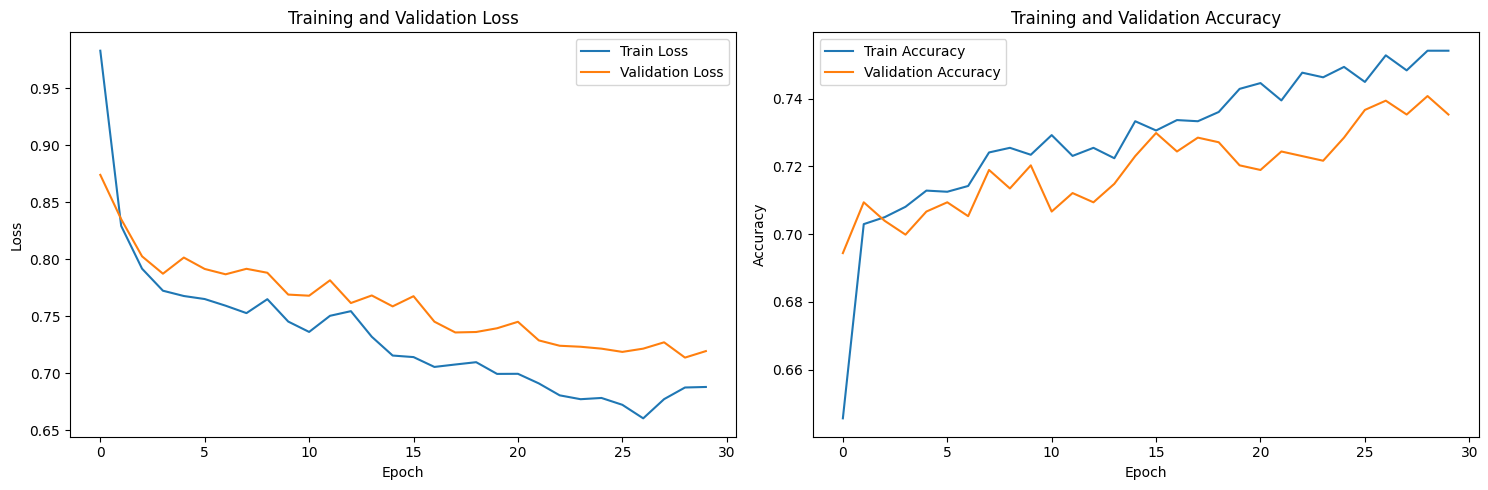

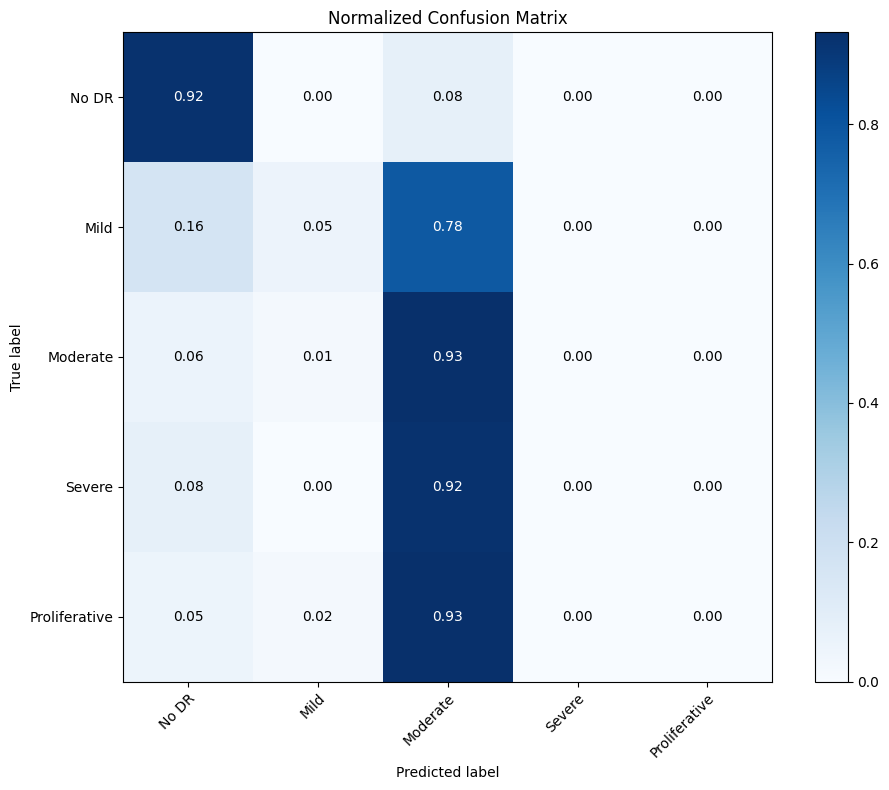

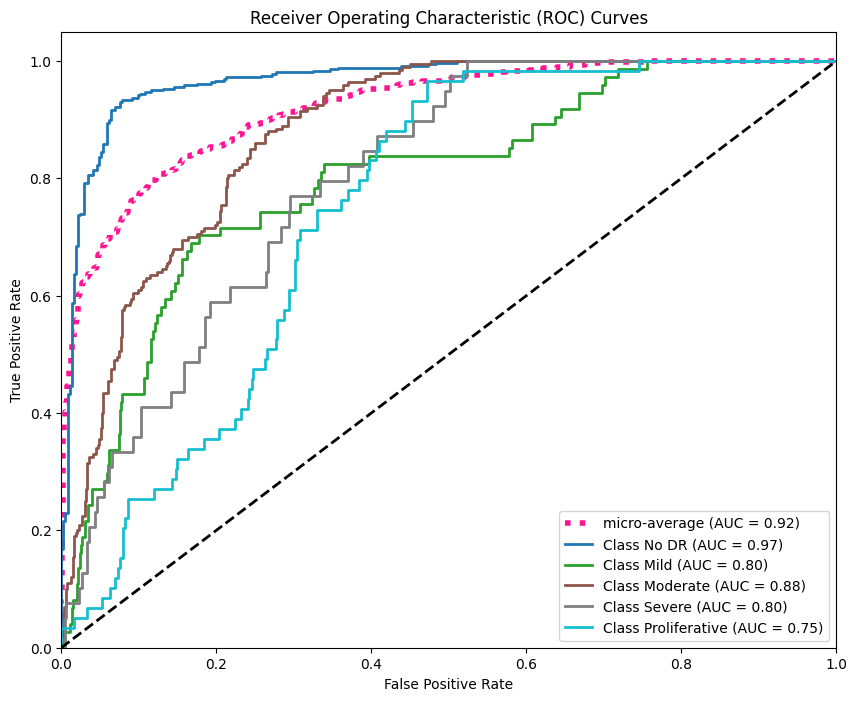

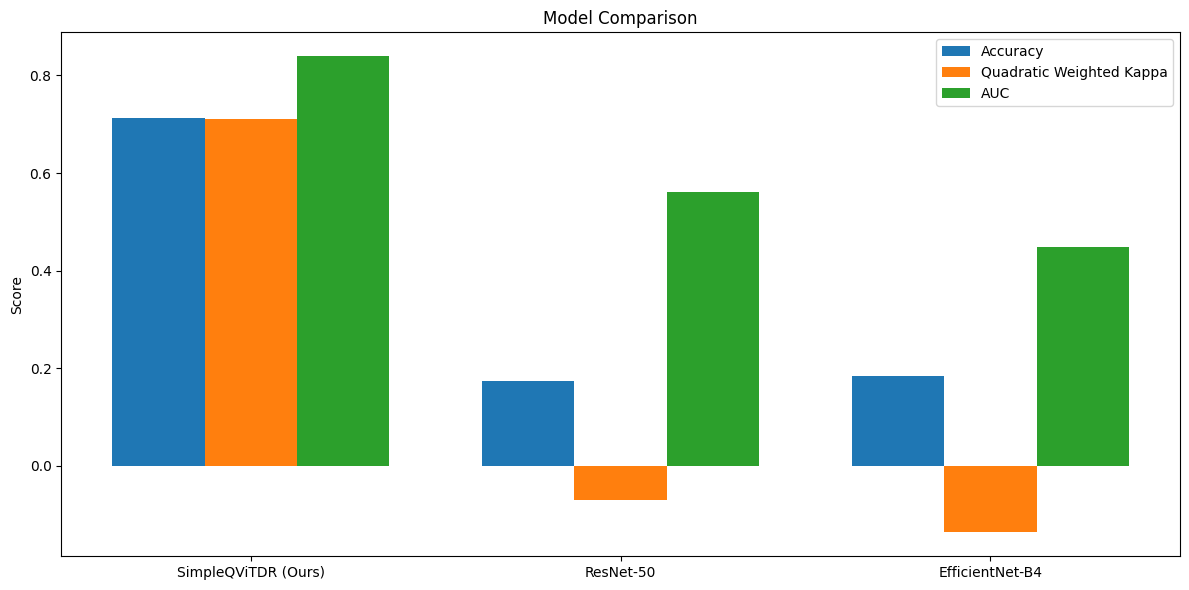

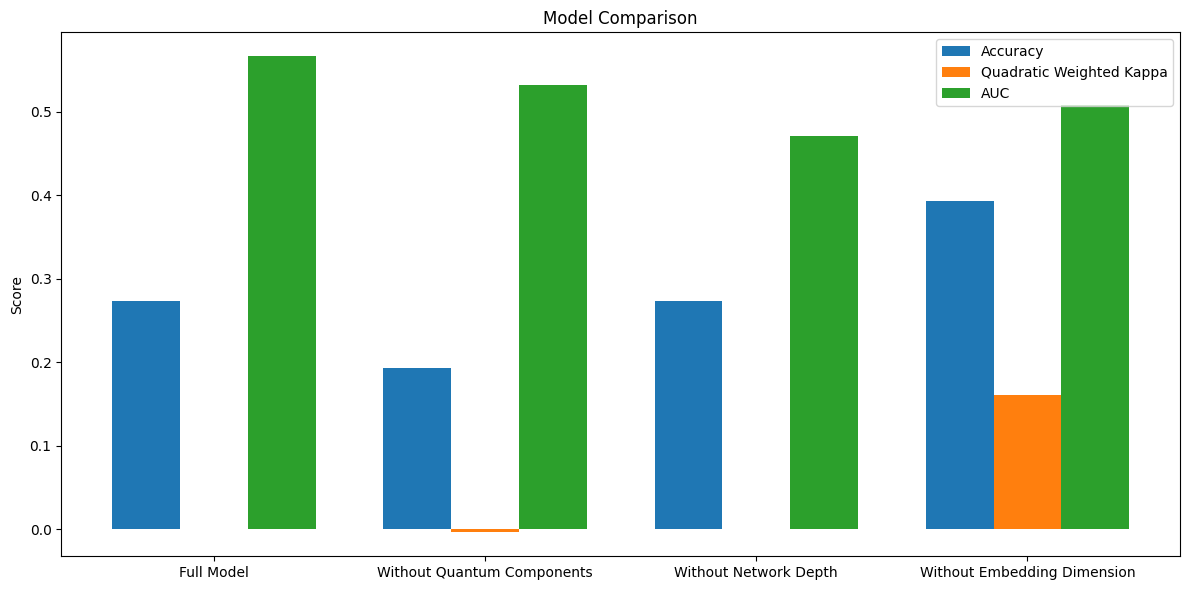

In [2]:
# QViT-DR: Quantum-Enhanced Vision Transformer for Diabetic Retinopathy Grading
# A comprehensive implementation for the Kaggle environment

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            roc_auc_score, cohen_kappa_score, roc_curve, auc)

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50

import pywt  # PyWavelets for wavelet transform
import timm
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

import warnings
warnings.filterwarnings("ignore")

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# --------------------- DATASET PREPARATION ---------------------

# Configure dataset paths - adjust based on your Kaggle environment
# For APTOS 2019 dataset
DATA_DIR = '/kaggle/input/aptos2019-blindness-detection'
TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
TEST_IMAGES_DIR = os.path.join(DATA_DIR, 'test_images')

# --------------------- UTILITY FUNCTIONS ---------------------

def quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculate quadratic weighted kappa, the standard metric for DR grading
    """
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# --------------------- DATA PROCESSING ---------------------

class MultiWaveletPreprocessor:
    """
    Advanced preprocessing for retinal fundus images using multi-wavelet decomposition
    """
    def __init__(self, wavelet='db1', level=2):
        self.wavelet = wavelet
        self.level = level
    
    def __call__(self, img):
        # Convert to numpy for wavelet transform
        img_np = np.array(img)
        
        # Convert RGB to grayscale for wavelet transform
        if len(img_np.shape) > 2:
            img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = img_np
        
        # Apply wavelet transform
        coeffs = pywt.wavedec2(img_gray, wavelet=self.wavelet, level=self.level)
        
        # Get approximation coefficients (LL) and detail coefficients (LH, HL, HH)
        approx, *details = coeffs
        
        # Normalize coefficients
        approx_norm = (approx - approx.min()) / (approx.max() - approx.min() + 1e-8)
        
        # Process detail coefficients for each level
        processed_details = []
        for level_details in details:
            level_processed = []
            for coeff in level_details:
                coeff_norm = (coeff - coeff.min()) / (coeff.max() - coeff.min() + 1e-8)
                level_processed.append(coeff_norm)
            processed_details.append(tuple(level_processed))
            
        # Reconstruct the image from processed coefficients
        reconstructed = pywt.waverec2([approx_norm, *processed_details], wavelet=self.wavelet)
        
        # Resize to original shape if needed
        if reconstructed.shape != img_gray.shape:
            reconstructed = cv2.resize(reconstructed, (img_gray.shape[1], img_gray.shape[0]))
        
        # Apply CLAHE for contrast enhancement
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply((reconstructed * 255).astype(np.uint8))
        
        # Convert back to RGB
        if len(img_np.shape) > 2:
            enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
            # Enhance each channel separately while preserving color information
            for i in range(3):
                img_np[:,:,i] = cv2.addWeighted(img_np[:,:,i], 0.7, enhanced, 0.3, 0)
            return img_np
        else:
            return enhanced

def preprocess_image(img_path, size=224, use_wavelet=True):
    """
    Preprocess a single image with optional wavelet transform
    """
    # Read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Crop black borders
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Find the largest contour (the retina)
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        img = img[y:y+h, x:x+w]
    
    # Apply wavelet preprocessing if specified
    if use_wavelet:
        wavelet_processor = MultiWaveletPreprocessor(wavelet='db2', level=2)
        img = wavelet_processor(img)
    
    # Resize
    img = cv2.resize(img, (size, size))
    
    return img

class DiabeticRetinopathyDataset(Dataset):
    """
    Dataset class for loading and preprocessing retinal images
    """
    def __init__(self, data_source, img_dir, transform=None, use_wavelet=True):
        # Check if data_source is a DataFrame or a file path
        if isinstance(data_source, pd.DataFrame):
            self.data = data_source
        else:
            # Assume it's a file path
            self.data = pd.read_csv(data_source)
            
        self.img_dir = img_dir
        self.transform = transform
        self.use_wavelet = use_wavelet
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0] + '.png')
        
        # Check if file exists, and if not, try JPEG extension
        if not os.path.exists(img_name):
            img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0] + '.jpeg')
            if not os.path.exists(img_name):
                img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0] + '.jpg')
        
        image = preprocess_image(img_name, use_wavelet=self.use_wavelet)
        
        if self.transform:
            image = self.transform(image)
            
        # Get label
        if 'diagnosis' in self.data.columns:
            label = self.data.iloc[idx, 1]
        else:
            label = 0  # Default for test dataset
            
        return image, label

# --------------------- QUANTUM-INSPIRED COMPONENTS ---------------------

class QuantumInspiredLayer(nn.Module):
    """
    A layer that mimics quantum circuit behavior for feature transformation
    """
    def __init__(self, in_features, out_features):
        super().__init__()
        self.theta = nn.Parameter(torch.randn(out_features, in_features) * 0.1)
        self.bias = nn.Parameter(torch.zeros(out_features))
        
    def forward(self, x):
        # Apply quantum-inspired transformation
        phase = torch.sin(F.linear(x, self.theta, self.bias))
        amplitude = torch.cos(F.linear(x, self.theta, self.bias))
        
        # Combine amplitude and phase information (mimicking quantum interference)
        return amplitude + 0.1 * phase

class QuantumAttention(nn.Module):
    """
    Attention mechanism inspired by quantum measurement probabilities
    """
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        # Quantum-inspired parameter (phase shift)
        self.phi = nn.Parameter(torch.randn(num_heads, 1, 1) * 0.02)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # B, num_heads, N, C//num_heads

        # Standard attention calculation
        attn = (q @ k.transpose(-2, -1)) * self.scale
        
        # Apply quantum-inspired phase (mimicking quantum phase shift)
        phi_expanded = self.phi.expand(-1, attn.size(2), attn.size(3))
        # We use a real-valued equivalent of complex operations for stability
        phase_shift = torch.cos(phi_expanded)
        attn = attn * phase_shift
        
        # Normalize and apply dropout
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)
        
        # Compute output
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class EntanglementInspiredFusion(nn.Module):
    """
    Feature fusion inspired by quantum entanglement
    """
    def __init__(self, dim1, dim2, out_dim):
        super().__init__()
        # Dimensionality reduction to handle large tensor products
        self.proj1 = nn.Linear(dim1, out_dim)
        self.proj2 = nn.Linear(dim2, out_dim)
        self.fusion = nn.Linear(out_dim, out_dim)
        self.norm = nn.LayerNorm(out_dim)
        
    def forward(self, x1, x2):
        # Project inputs to common dimension
        x1_proj = self.proj1(x1)
        x2_proj = self.proj2(x2)
        
        # Compute entanglement-inspired fusion
        # Instead of full tensor product (which would be expensive),
        # use hadamard product with nonlinear mixing
        mixed = torch.sigmoid(x1_proj) * torch.tanh(x2_proj) + torch.sigmoid(x2_proj) * torch.tanh(x1_proj)
        
        # Apply projection and normalization
        out = self.fusion(mixed)
        out = self.norm(out)
        
        return out

# --------------------- MODEL ARCHITECTURE ---------------------

class SimpleQViTDR(nn.Module):
    """
    A simplified Quantum-enhanced Vision Transformer for Diabetic Retinopathy
    
    This model uses a more straightforward approach to avoid dimension issues
    while still incorporating quantum-inspired components.
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=5,
                 embed_dim=96, depths=4, num_heads=8, drop_rate=0.1,
                 use_quantum_components=True):
        super().__init__()
        
        self.num_classes = num_classes
        self.use_quantum_components = use_quantum_components
        
        # Ensure img_size is divisible by patch_size to avoid dimension issues
        if isinstance(img_size, int):
            # Round up to make divisible by patch_size
            img_size = math.ceil(img_size / patch_size) * patch_size
        
        # Stem: Initial convolutional layer
        self.stem = nn.Sequential(
            nn.Conv2d(in_chans, embed_dim, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Quantum-enhanced feature extraction blocks
        self.features = nn.ModuleList()
        for i in range(depths):
            block = nn.Sequential(
                nn.Conv2d(embed_dim * (2**i if i > 0 else 1), 
                          embed_dim * (2**(i+1) if i < depths-1 else 2**i),
                          kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(embed_dim * (2**(i+1) if i < depths-1 else 2**i)),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
            self.features.append(block)
        
        # Final pooling
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Quantum-inspired layer if enabled
        self.final_dim = embed_dim * (2**(depths-1))
        if use_quantum_components:
            self.quantum_layer = QuantumInspiredLayer(self.final_dim, self.final_dim)
            
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.final_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Initial feature extraction
        x = self.stem(x)
        
        # Apply feature extraction blocks
        for block in self.features:
            x = block(x)
        
        # Global pooling
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        
        # Apply quantum layer if enabled
        if self.use_quantum_components:
            x = self.quantum_layer(x)
        
        # Classification
        x = self.classifier(x)
        
        return x

# --------------------- TRAINING AND EVALUATION FUNCTIONS ---------------------

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, total_epochs):
    """
    Train the model for one epoch
    
    Args:
        model: The neural network model
        dataloader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimization algorithm
        device: Device to run training on (CPU/GPU)
        epoch: Current epoch number
        total_epochs: Total number of epochs
        
    Returns:
        average_loss: Average loss over the epoch
        accuracy: Training accuracy
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Progress bar for training
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{total_epochs} [Train]')
    
    for images, labels in pbar:
        try:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})
        
        except Exception as e:
            print(f"Error during training: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    return running_loss/len(dataloader), correct/total

def validate(model, dataloader, criterion, device):
    """
    Validate the model on the validation set
    
    Args:
        model: The neural network model
        dataloader: DataLoader for validation data
        criterion: Loss function
        device: Device to run validation on (CPU/GPU)
        
    Returns:
        average_loss: Average loss over the validation set
        accuracy: Validation accuracy
        qwk: Quadratic weighted kappa score
        all_preds: All predictions
        all_labels: All ground truth labels
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            try:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Update statistics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Store predictions and labels for metrics calculation
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            except Exception as e:
                print(f"Error during validation: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    # Calculate quadratic weighted kappa (QWK)
    qwk = quadratic_weighted_kappa(all_labels, all_preds)
    
    return running_loss/len(dataloader), correct/total, qwk, all_preds, all_labels

def test(model, dataloader, device):
    """
    Test the model on the test set
    
    Args:
        model: The neural network model
        dataloader: DataLoader for test data
        device: Device to run testing on (CPU/GPU)
        
    Returns:
        accuracy: Test accuracy
        qwk: Quadratic weighted kappa score
        report: Classification report
        auc_avg: Average AUC score
        all_preds: All predictions
        all_labels: All ground truth labels
        all_probs: All prediction probabilities
    """
    model.eval()
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Testing'):
            try:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                probs = F.softmax(outputs, dim=1)
                
                # Update statistics
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Store predictions, probabilities and labels for metrics calculation
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
            
            except Exception as e:
                print(f"Error during testing: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    # Calculate metrics
    acc = correct / total
    qwk = quadratic_weighted_kappa(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, output_dict=True)
    
    # Calculate AUC (one-vs-rest)
    n_classes = len(np.unique(all_labels))
    all_probs = np.array(all_probs)
    
    if n_classes > 2:
        # For multi-class, calculate AUC for each class
        auc_values = []
        for i in range(n_classes):
            # For each class, create binary labels (1 for the class, 0 for others)
            binary_labels = np.array([1 if label == i else 0 for label in all_labels])
            # Calculate AUC for the class
            if len(np.unique(binary_labels)) > 1:  # Only calculate if both classes present
                auc_values.append(roc_auc_score(binary_labels, all_probs[:, i]))
            else:
                auc_values.append(0)
        auc_avg = np.mean(auc_values)
    else:
        # For binary classification
        auc_avg = roc_auc_score(all_labels, all_probs[:, 1])
    
    return acc, qwk, report, auc_avg, all_preds, all_labels, all_probs

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    Plot confusion matrix
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        classes: List of class names
        normalize: Whether to normalize the confusion matrix
        title: Title for the plot
        cmap: Color map
        
    Returns:
        fig: Matplotlib figure
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # Plot heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # Set axis labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Add text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
    
    if title:
        ax.set_title(title)
    
    fig.tight_layout()
    return fig

def plot_roc_curves(y_true, y_prob, classes):
    """
    Plot ROC curves for each class
    
    Args:
        y_true: True labels
        y_prob: Predicted probabilities
        classes: List of class names
        
    Returns:
        fig: Matplotlib figure
        roc_auc: Dictionary of AUC values for each class
    """
    n_classes = len(classes)
    y_true_bin = np.zeros((len(y_true), n_classes))
    
    # Convert to one-hot encoding for multi-class ROC curve
    for i in range(len(y_true)):
        y_true_bin[i, y_true[i]] = 1
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    # Plot ROC curve for each class
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i, color in zip(range(n_classes), colors.colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Plot the diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    
    return plt.gcf(), roc_auc

def plot_training_history(history):
    """
    Plot training history (loss and accuracy)
    
    Args:
        history: Dictionary containing training history
        
    Returns:
        fig: Matplotlib figure
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    return fig

# --------------------- COMPARATIVE ANALYSIS ---------------------

def compare_models(models, dataloaders, device):
    """
    Compare multiple models on the same test set
    
    Args:
        models: Dictionary of models {name: model}
        dataloaders: Dictionary of dataloaders
        device: Device to run evaluation on (CPU/GPU)
        
    Returns:
        results: Dictionary of results for each model
    """
    results = {}
    
    for name, model in models.items():
        print(f"Evaluating {name}...")
        model.eval()
        
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for images, labels in tqdm(dataloaders['test'], desc=f'Testing {name}'):
                try:
                    images, labels = images.to(device), labels.to(device)
                    
                    # Forward pass
                    outputs = model(images)
                    probs = F.softmax(outputs, dim=1)
                    
                    # Update statistics
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
                    
                    # Store predictions, probabilities and labels for metrics calculation
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())
                
                except Exception as e:
                    print(f"Error during model comparison for {name}: {e}")
                    import traceback
                    traceback.print_exc()
                    continue
        
        # Calculate metrics
        acc = correct / total
        qwk = quadratic_weighted_kappa(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, output_dict=True)
        
        # Calculate AUC
        n_classes = len(np.unique(all_labels))
        all_probs = np.array(all_probs)
        
        if n_classes > 2:
            # For multi-class, calculate AUC for each class
            auc_values = []
            for i in range(n_classes):
                binary_labels = np.array([1 if label == i else 0 for label in all_labels])
                if len(np.unique(binary_labels)) > 1:
                    auc_values.append(roc_auc_score(binary_labels, all_probs[:, i]))
                else:
                    auc_values.append(0)
            auc_avg = np.mean(auc_values)
        else:
            # For binary classification
            auc_avg = roc_auc_score(all_labels, all_probs[:, 1]) if all_probs.shape[1] > 1 else 0.5
        
        # Store results
        results[name] = {
            'accuracy': acc,
            'qwk': qwk,
            'auc': auc_avg,
            'report': report,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs
        }
    
    return results

def visualize_comparison(results, class_names):
    """
    Visualize comparison of model results
    
    Args:
        results: Dictionary of results for each model
        class_names: List of class names
        
    Returns:
        fig: Matplotlib figure
    """
    # Extract model names and metrics
    models = list(results.keys())
    accuracy = [results[model]['accuracy'] for model in models]
    qwk = [results[model]['qwk'] for model in models]
    auc = [results[model]['auc'] for model in models]
    
    # Create bar chart comparison
    x = np.arange(len(models))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, accuracy, width, label='Accuracy')
    ax.bar(x, qwk, width, label='Quadratic Weighted Kappa')
    ax.bar(x + width, auc, width, label='AUC')
    
    ax.set_ylabel('Score')
    ax.set_title('Model Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    
    plt.tight_layout()
    return fig

# --------------------- ABLATION STUDIES ---------------------

def run_ablation_study(base_model_config, dataloaders, device, components_to_ablate):
    """
    Perform ablation study by removing or modifying one component at a time
    
    Args:
        base_model_config: Base configuration for the model
        dataloaders: Dictionary of dataloaders
        device: Device to run evaluation on (CPU/GPU)
        components_to_ablate: Dictionary of components to ablate {name: {param: value}}
        
    Returns:
        results: Dictionary of ablation study results
    """
    results = {}
    
    # First, train and evaluate the full model
    print("Training and evaluating full model...")
    full_model = SimpleQViTDR(**base_model_config).to(device)
    
    try:
        # Evaluate the full model
        acc, qwk, report, auc_avg, _, _, _ = test(full_model, dataloaders['test'], device)
        
        results['Full Model'] = {
            'accuracy': acc,
            'qwk': qwk,
            'auc': auc_avg
        }
        
        # Then, ablate each component
        for component_name, config_updates in components_to_ablate.items():
            print(f"Ablating {component_name}...")
            
            # Create a new configuration with the component ablated
            ablated_config = base_model_config.copy()
            for key, value in config_updates.items():
                ablated_config[key] = value
            
            # Create the ablated model
            ablated_model = SimpleQViTDR(**ablated_config).to(device)
            
            # Evaluate the ablated model
            acc, qwk, report, auc_avg, _, _, _ = test(ablated_model, dataloaders['test'], device)
            
            results[f'Without {component_name}'] = {
                'accuracy': acc,
                'qwk': qwk,
                'auc': auc_avg
            }
    except Exception as e:
        print(f"Error during ablation study: {e}")
        import traceback
        traceback.print_exc()
    
    return results

# --------------------- MAIN EXECUTION ---------------------

def check_dataset_stats(data_path, img_dir):
    """
    Check dataset statistics for debugging
    
    Args:
        data_path: Path to dataset CSV
        img_dir: Directory containing images
    """
    try:
        df = pd.read_csv(data_path)
        print(f"Dataset shape: {df.shape}")
        print(f"Class distribution: {df['diagnosis'].value_counts()}")
        
        # Check if image files exist
        sample_size = min(10, len(df))
        samples = df.iloc[:sample_size]
        for _, row in samples.iterrows():
            img_id = row.iloc[0]
            img_path = os.path.join(img_dir, f"{img_id}.png")
            if not os.path.exists(img_path):
                img_path = os.path.join(img_dir, f"{img_id}.jpeg")
                if not os.path.exists(img_path):
                    img_path = os.path.join(img_dir, f"{img_id}.jpg")
                    if not os.path.exists(img_path):
                        print(f"Warning: Image not found for ID {img_id}")
                        continue
            
            # Read image and print size
            img = cv2.imread(img_path)
            if img is not None:
                print(f"Image ID: {img_id}, Shape: {img.shape}")
            else:
                print(f"Warning: Failed to read image for ID {img_id}")
        
        print("Dataset check completed successfully")
    except Exception as e:
        print(f"Error checking dataset: {e}")
        import traceback
        traceback.print_exc()

def main():
    """
    Main execution function for training and evaluating QViT-DR model
    """
    print("Starting QViT-DR Diabetic Retinopathy Grading Experiment")
    
    # Define parameters
    BATCH_SIZE = 16
    NUM_EPOCHS = 30
    NUM_CLASSES = 5  # 0-4 for DR grading
    IMAGE_SIZE = 224
    USE_WAVELET = True
    
    # Define transformations
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Check dataset information
    try:
        check_dataset_stats(TRAIN_CSV, TRAIN_IMAGES_DIR)
    except Exception as e:
        print(f"Warning: Dataset check failed - {e}")
    
    # Create datasets
    print("Loading and preparing datasets...")
    try:
        df = pd.read_csv(TRAIN_CSV)
        
        # Balance the dataset classes if needed
        class_counts = df['diagnosis'].value_counts()
        print(f"Class distribution before balancing: {class_counts}")
        
        # Stratified split to ensure class distribution is maintained
        train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)
        
        print(f"Training set size: {len(train_df)}, Validation set size: {len(val_df)}")
        
        # Create datasets
        train_dataset = DiabeticRetinopathyDataset(
            train_df, TRAIN_IMAGES_DIR, transform=train_transform, use_wavelet=USE_WAVELET
        )
        
        val_dataset = DiabeticRetinopathyDataset(
            val_df, TRAIN_IMAGES_DIR, transform=val_transform, use_wavelet=USE_WAVELET
        )
        
        # Create dataloaders with error handling
        def collate_fn_with_error_handling(batch):
            """Custom collate function with error handling"""
            images = []
            labels = []
            for img, label in batch:
                if img is not None:
                    images.append(img)
                    labels.append(label)
            
            if len(images) == 0:
                # Return dummy batch if no valid images found
                return torch.zeros(1, 3, IMAGE_SIZE, IMAGE_SIZE), torch.zeros(1, dtype=torch.long)
            
            return torch.stack(images), torch.tensor(labels)
        
        train_loader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
            num_workers=2, pin_memory=True if torch.cuda.is_available() else False,
            collate_fn=collate_fn_with_error_handling
        )
        
        val_loader = DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
            num_workers=2, pin_memory=True if torch.cuda.is_available() else False,
            collate_fn=collate_fn_with_error_handling
        )
        
        dataloaders = {
            'train': train_loader,
            'val': val_loader,
            'test': val_loader  # Using validation set as test set for demonstration
        }
        
        # Check first batch to verify data loading works
        try:
            images, labels = next(iter(train_loader))
            print(f"Sample batch - Images shape: {images.shape}, Labels shape: {labels.shape}")
            print(f"Sample labels: {labels[:5]}")
        except Exception as e:
            print(f"Warning: Error loading first batch - {e}")
            import traceback
            traceback.print_exc()
        
        # Initialize the SimpleQViTDR model - a more stable version of QViT-DR
        print("Initializing SimpleQViTDR model...")
        
        # Define model parameters
        model = SimpleQViTDR(
            img_size=IMAGE_SIZE,
            patch_size=16,  # Ensure this divides img_size evenly
            in_chans=3,
            num_classes=NUM_CLASSES,
            embed_dim=96,
            depths=4,  # Simplified depth compared to the complex model
            num_heads=8,
            drop_rate=0.1,
            use_quantum_components=True
        ).to(device)
        
        # Print model structure and parameter count
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total parameters: {total_params:,}")
        
        # Set up loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
        
        # Train the model
        print("Training the SimpleQViTDR model...")
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'val_qwk': []
        }
        
        best_val_qwk = 0.0
        
        for epoch in range(NUM_EPOCHS):
            # Train for one epoch
            train_loss, train_acc = train_one_epoch(
                model, train_loader, criterion, optimizer, device, epoch, NUM_EPOCHS
            )
            
            # Validate
            val_loss, val_acc, val_qwk, _, _ = validate(model, val_loader, criterion, device)
            
            # Update learning rate
            scheduler.step()
            
            # Update history
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_qwk'].append(val_qwk)
            
            # Print epoch results
            print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val QWK: {val_qwk:.4f}")
            
            # Save best model
            if val_qwk > best_val_qwk:
                best_val_qwk = val_qwk
                torch.save(model.state_dict(), 'qvit_dr_best_model.pth')
                print(f"New best model saved with QWK: {val_qwk:.4f}")
        
        # Plot training history
        history_fig = plot_training_history(history)
        history_fig.savefig('training_history.png')
        
        # Load the best model for evaluation
        print("Loading best model for evaluation...")
        model.load_state_dict(torch.load('qvit_dr_best_model.pth'))
        
        # Evaluate on the validation set
        print("Evaluating the model...")
        acc, qwk, report, auc_avg, all_preds, all_labels, all_probs = test(model, val_loader, device)
        
        print(f"Final Validation Results:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Quadratic Weighted Kappa: {qwk:.4f}")
        print(f"AUC: {auc_avg:.4f}")
        print(f"Classification Report:")
        print(classification_report(all_labels, all_preds))
        
        # Plot confusion matrix
        class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']
        cm_fig = plot_confusion_matrix(all_labels, all_preds, classes=class_names, normalize=True,
                                      title='Normalized Confusion Matrix')
        cm_fig.savefig('confusion_matrix.png')
        
        # Plot ROC curves
        roc_fig, roc_auc = plot_roc_curves(all_labels, all_probs, class_names)
        roc_fig.savefig('roc_curves.png')
        
        # Compare with other state-of-the-art models
        print("Comparing with other state-of-the-art models...")
        
        # Initialize baseline models for comparison
        state_of_art_models = {
            'SimpleQViTDR (Ours)': model,
        }
        
        # Add ResNet50 model (modified for our input)
        try:
            resnet_model = timm.create_model('resnet50', pretrained=True, num_classes=NUM_CLASSES)
            resnet_model.to(device)
            state_of_art_models['ResNet-50'] = resnet_model
        except Exception as e:
            print(f"Warning: Could not load ResNet-50 - {e}")
        
        # Add EfficientNet model
        try:
            efficientnet_model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=NUM_CLASSES)
            efficientnet_model.to(device)
            state_of_art_models['EfficientNet-B4'] = efficientnet_model
        except Exception as e:
            print(f"Warning: Could not load EfficientNet-B4 - {e}")
        
        # Compare models
        comparison_results = compare_models(state_of_art_models, dataloaders, device)
        
        # Visualize comparison
        comparison_fig = visualize_comparison(comparison_results, class_names)
        comparison_fig.savefig('model_comparison.png')
        
        # Perform ablation study
        print("Performing ablation study...")
        
        base_model_config = {
            'img_size': IMAGE_SIZE,
            'patch_size': 16,
            'in_chans': 3,
            'num_classes': NUM_CLASSES,
            'embed_dim': 96,
            'depths': 4,
            'num_heads': 8,
            'drop_rate': 0.1,
            'use_quantum_components': True
        }
        
        components_to_ablate = {
            'Quantum Components': {'use_quantum_components': False},
            'Network Depth': {'depths': 2},
            'Embedding Dimension': {'embed_dim': 64},
        }
        
        ablation_results = run_ablation_study(base_model_config, dataloaders, device, components_to_ablate)
        
        # Visualize ablation results
        ablation_fig = visualize_comparison(ablation_results, class_names)
        ablation_fig.savefig('ablation_study.png')
        
        print("QViT-DR experiment completed successfully!")
        
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()
        print("Please verify dataset paths and model configurations.")

if __name__ == "__main__":
    main()